In [1]:
#!pip install -r requirements.txt

In [2]:

import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import opendatasets as od
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-10-11 14:10:17.844936: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 14:10:17.848689: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 14:10:17.859797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 14:10:17.877610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 14:10:17.882883: E external/loc

In [3]:

# Set paths and constants
base_path = './covid19normalpneumonia-ct-images'
classes = ['COVID2_CT', 'Normal_CT', 'pneumonia_CT']
num_images_to_keep = 20
num_augmentations_per_image = 5
img_size = (256, 256)
augmented_path = 'AugmentedData'  # Path to save augmented images

In [ ]:

# Download dataset
#od.download("https://www.kaggle.com/datasets/anaselmasry/covid19normalpneumonia-ct-images/data")


In [5]:
!desc covid19normalpneumonia-ct-images

Meta Data of covid19normalpneumonia-ct-images 
-----------------------------------
Folder Name          | Files
-----------------------------------
COVID2_CT            | 2035 
Normal_CT            | 2119 
pneumonia_CT         | 3390 
-----------------------------------
Total                | 7544 
-----------------------------------


In [6]:

def keep_random_files(directory, num_to_keep):
    """Keep only a specified number of random files in a directory."""
    files = os.listdir(directory)
    if len(files) > num_to_keep:
        files_to_keep = set(random.sample(files, num_to_keep))
        for file in files:
            if file not in files_to_keep:
                os.remove(os.path.join(directory, file))

# Clean dataset
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    print(f"Processing {class_name}...")
    keep_random_files(class_path, num_images_to_keep)
print("Cleanup completed.")


Processing COVID2_CT...
Processing Normal_CT...
Processing pneumonia_CT...
Cleanup completed.


In [7]:
!desc covid19normalpneumonia-ct-images

Meta Data of covid19normalpneumonia-ct-images 
-----------------------------------
Folder Name          | Files
-----------------------------------
COVID2_CT            | 20   
Normal_CT            | 20   
pneumonia_CT         | 20   
-----------------------------------
Total                | 60   
-----------------------------------


In [8]:
def augment_image(img_path, augmented_class_path, img_file, i, datagen):
    """Augment a single image and save the result."""
    img_array = img_to_array(load_img(img_path)).reshape((1,) + img_to_array(load_img(img_path)).shape)
    aug_iter = datagen.flow(img_array, batch_size=1)
    
    augmented_img = next(aug_iter)[0].astype(np.uint8)
    save_path = os.path.join(augmented_class_path, f"augmented_{img_file.split('.')[0]}_{i}.jpg")
    cv2.imwrite(save_path, augmented_img)

def augment_images(class_name):
    """Augment images for a specified class."""
    class_path = os.path.join(base_path, class_name)
    augmented_class_path = os.path.join(augmented_path, class_name)
    os.makedirs(augmented_class_path, exist_ok=True)

    print(f"{class_name}: {len(os.listdir(class_path))} images started augmentation")
    
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    image_files = os.listdir(class_path)
    
    with ThreadPoolExecutor() as executor:
        for img_file in image_files:
            img_path = os.path.join(class_path, img_file)
            for i in range(num_augmentations_per_image):
                executor.submit(augment_image, img_path, augmented_class_path, img_file, i, datagen)

    print(f"{class_name}: Augmentation completed.")

# Perform augmentation for each class
for class_name in classes:
    augment_images(class_name)

print("Augmentation completed.")


COVID2_CT: 20 images started augmentation
COVID2_CT: Augmentation completed.
Normal_CT: 20 images started augmentation
Normal_CT: Augmentation completed.
pneumonia_CT: 20 images started augmentation
pneumonia_CT: Augmentation completed.
Augmentation completed.


In [9]:
!desc AugmentedData

Meta Data of AugmentedData 
-----------------------------------
Folder Name          | Files
-----------------------------------
COVID2_CT            | 100  
Normal_CT            | 100  
pneumonia_CT         | 100  
-----------------------------------
Total                | 300  
-----------------------------------


In [10]:


# Create masks for images
mask_base_path = './masks'
os.makedirs(mask_base_path, exist_ok=True)
for class_name in classes:
    os.makedirs(os.path.join(mask_base_path, class_name), exist_ok=True)

def generate_mask(image_path):
    """Generate a mask for a given image using thresholding."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return mask

def process_image_and_save_mask(img_file, img_dir, mask_dir):
    """Process an image and save its corresponding mask."""
    img_path = os.path.join(img_dir, img_file)
    mask = generate_mask(img_path)
    if mask is not None:
        mask_filename = f"mask_{img_file}"
        mask_path = os.path.join(mask_dir, mask_filename)
        cv2.imwrite(mask_path, mask)

def create_masks_for_class(class_name, augmented=False):
    """Create masks for images in a specific class."""
    img_dir = os.path.join(augmented_path if augmented else base_path, class_name)
    mask_dir = os.path.join(mask_base_path, class_name)
    img_files = os.listdir(img_dir)

    with ProcessPoolExecutor() as executor:
        for img_file in img_files:
            executor.submit(process_image_and_save_mask, img_file, img_dir, mask_dir)

# Create masks for both original and augmented images
for class_name in classes:
    create_masks_for_class(class_name)  # Original images
    create_masks_for_class(class_name, augmented=True)  # Augmented images
print("Masks created.")


Masks created.


In [11]:
! desc masks/

Meta Data of masks/ 
-----------------------------------
Folder Name          | Files
-----------------------------------
COVID2_CT            | 120  
Normal_CT            | 120  
pneumonia_CT         | 120  
-----------------------------------
Total                | 360  
-----------------------------------


Displaying images and masks for: COVID2_CT


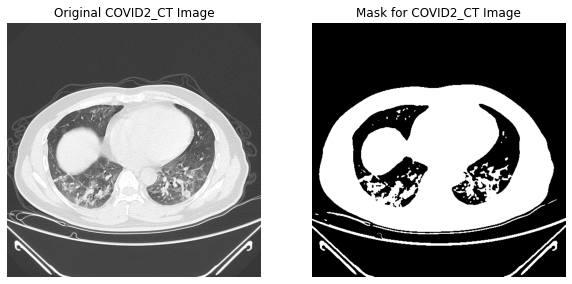

Displaying images and masks for: Normal_CT


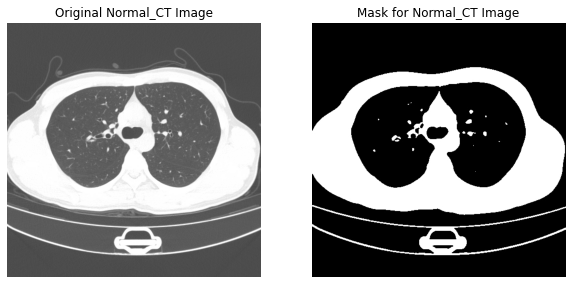

Displaying images and masks for: pneumonia_CT


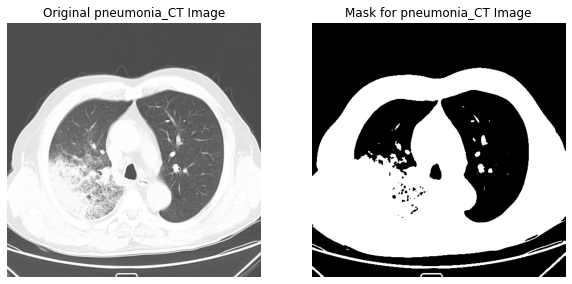

In [12]:

def display_images_with_mask(image_class):
    """Display an original image and its mask for a specified class."""
    img_dir = os.path.join(base_path, image_class)
    mask_dir = os.path.join(mask_base_path, image_class)
    original_image_file = os.listdir(img_dir)[0]

    img_path = os.path.join(img_dir, original_image_file)
    mask_path = os.path.join(mask_dir, f'mask_{original_image_file}')

    img = cv2.imread(img_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f'Original {image_class} Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask for {image_class} Image')
    plt.axis('off')
    #plt.savefig('Original_vs_Mask.png')
    plt.show()

# Display images for each class
for class_name in classes:
    print(f"Displaying images and masks for: {class_name}")
    display_images_with_mask(class_name)



In [13]:

# U-Net Model Definition
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
model = unet_model(input_size=(256, 256, 3))
model.summary()


2024-10-11 14:11:11.747945: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

# Load Images and Masks
image_base_path = './covid19normalpneumonia-ct-images'
mask_base_path = './masks'
img_size = (256, 256)  # Resize all images to 256x256

def load_images_and_masks(classes, num_images=None):
    images = []
    masks = []

    for class_name in classes:
        img_dir = os.path.join(image_base_path, class_name)
        mask_dir = os.path.join(mask_base_path, class_name)

        img_files = os.listdir(img_dir)
        if num_images:
            img_files = img_files[:num_images]  # Load only a subset if specified

        for img_file in img_files:
            img_path = os.path.join(img_dir, img_file)
            mask_path = os.path.join(mask_dir, f'mask_{img_file}')

            # Load and resize the image
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize image

            # Load and resize the mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize mask to 0-1 range

            # Append to lists
            images.append(img)
            masks.append(np.expand_dims(mask, axis=-1))  # Add a channel dimension to the mask

    return np.array(images), np.array(masks)

# Load the dataset (you can limit the number of images with num_images for faster testing)
classes = ['COVID2_CT', 'Normal_CT', 'pneumonia_CT']
images, masks = load_images_and_masks(classes)


In [15]:

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [16]:

# Compile the Model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', MeanIoU(num_classes=2)])  # Adjust num_classes for multiclass segmentation

# Define Callbacks
checkpoint = ModelCheckpoint('unet_lung_segmentation.keras',  # Save as .keras format
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [17]:

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=16,
                    callbacks=[checkpoint, early_stop])


Epoch 1/50


/home/ddp/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.2744 - loss: 0.6901 - mean_io_u: 0.3633 - val_accuracy: 0.2770 - val_loss: 0.6868 - val_mean_io_u: 0.3615
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.2711 - loss: 0.6872 - mean_io_u: 0.3646 - val_accuracy: 0.2772 - val_loss: 0.6838 - val_mean_io_u: 0.3615
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.2789 - loss: 0.6828 - mean_io_u: 0.3611 - val_accuracy: 0.2777 - val_loss: 0.6799 - val_mean_io_u: 0.3615
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.2818 - loss: 0.6797 - mean_io_u: 0.3612 - val_accuracy: 0.2794 - val_loss: 0.6744 - val_mean_io_u: 0.3615
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.2996 - loss: 0.6739 - mean_io_u: 0.3628 - val_accuracy: 0.2852 - val_loss: 0.6648 - val_mean_io_u: 0.3615
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.3133 - loss: 0.6630 - mean_io_u: 0.3627 - val_accuracy: 0.4145 - val_loss: 0.6468 - val_mean_io_u: 0.3615
Epo

/tmp/ipykernel_137538/2224750933.py:22: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


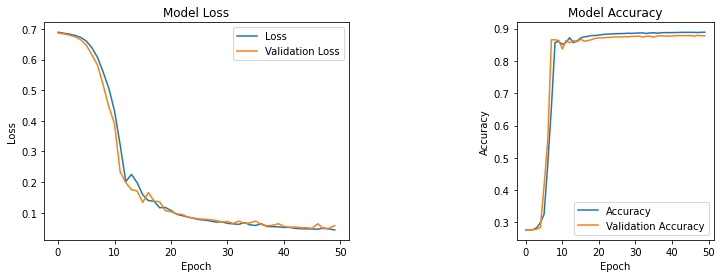

Training completed.


In [19]:

# Plot training history
def plot_training_history(history):
    """Plot training and validation loss and IoU metrics."""
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

print("Training completed.")

